## **Import Libraries**

In [12]:
import numpy as np # Basic linear algebra
from prettytable import PrettyTable # Table formatting

# Imputer
from sklearn.experimental import enable_iterative_imputer # Enable IterativeImputer
from sklearn.impute import IterativeImputer # Imputer handling missing values
from sklearn.ensemble import RandomForestRegressor # External Random Forest Regressor for imputation of missing values

# Data Visualization
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

# Data Preprocessing
from sklearn.model_selection import train_test_split # Splitting data into train and test sets

import warnings # Ignore warnings
warnings.filterwarnings("ignore")

## **Create Random Forest Model**

### Node Class

In [7]:
class Node:
    """
    Represents a node in a decision tree.

    Attributes:
        gini (float): The Gini impurity of the node.
        num_samples (int): The total number of samples in the node.
        num_samples_per_class (list): The number of samples per class in the node.
        predicted_class (int): The predicted class for the node.
        feature_index (int): The index of the feature used for splitting the node.
        threshold (float): The threshold value used for splitting the node.
        left (Node): The left child node.
        right (Node): The right child node.
    """

    def __init__(self, gini, num_samples, num_samples_per_class, predicted_class):
        self.gini = gini
        self.num_samples = num_samples
        self.num_samples_per_class = num_samples_per_class
        self.predicted_class = predicted_class
        self.feature_index = 0
        self.threshold = 0
        self.left = None
        self.right = None

### Decision Tree Classifier Class

In [ ]:
class DecisionTreeClassifier:
    """
    Decision tree classifier.

    Parameters
    ----------
    max_depth : int, optional (default=None)
        The maximum depth of the tree. If None, then nodes are expanded until all leaves are pure.
    min_samples_leaf : int, optional (default=1)
        The minimum number of samples required to be at a leaf node.

    Attributes
    ----------
    n_classes_ : int
        The number of classes.
    n_features_ : int
        The number of features when `fit` is performed.
    tree_ : Node
        The root of the decision tree.

    Methods
    -------
    fit(X, y)
        Build a decision tree classifier from the training set (X, y).
    predict(X)
        Predict class for X.
    _gini(y)
        Compute Gini impurity of a non-empty node.
    _best_split(X, y)
        Find the best split for a node.
    _grow_tree(X, y, depth)
        Build a decision tree by recursively finding the best split.
    _predict(inputs)
        Predict class for a single sample.
    """
    def __init__(self, max_depth=None, min_samples_leaf=1):
        self.max_depth = max_depth
        self.min_samples_leaf = min_samples_leaf
        self.tree_ = None

    def fit(self, X, y):
        self.n_classes_ = len(set(y))
        self.n_features_ = X.shape[1]
        self.tree_ = self._grow_tree(X, y)

    def predict(self, X):
        return [self._predict(inputs) for inputs in X]

    def _gini(self, y):
        m = len(y)
        return 1.0 - sum((np.sum(y == c) / m) ** 2 for c in range(self.n_classes_))

    def _best_split(self, X, y):
        m, n = X.shape
        if m <= self.min_samples_leaf:
            return None, None

        num_parent = [np.sum(y == c) for c in range(self.n_classes_)]
        best_gini = 1.0 - sum((n / m) ** 2 for n in num_parent)
        best_idx, best_thr = None, None

        for idx in range(n):
            thresholds, classes = zip(*sorted(zip(X[:, idx], y)))
            num_left = [0] * self.n_classes_
            num_right = num_parent.copy()
            for i in range(1, m):
                c = classes[i - 1]
                num_left[c] += 1
                num_right[c] -= 1
                gini_left = 1.0 - sum((num_left[x] / i) ** 2 for x in range(self.n_classes_))
                gini_right = 1.0 - sum((num_right[x] / (m - i)) ** 2 for x in range(self.n_classes_))
                gini = (i * gini_left + (m - i) * gini_right) / m
                if thresholds[i] == thresholds[i - 1]:
                    continue
                if gini < best_gini:
                    best_gini = gini
                    best_idx = idx
                    best_thr = (thresholds[i] + thresholds[i - 1]) / 2

        return best_idx, best_thr

    def _grow_tree(self, X, y, depth=0):
        num_samples_per_class = [np.sum(y == i) for i in range(self.n_classes_)]
        predicted_class = np.argmax(num_samples_per_class)
        node = Node(
            gini=self._gini(y),
            num_samples=len(y),
            num_samples_per_class=num_samples_per_class,
            predicted_class=predicted_class,
        )

        if depth < self.max_depth:
            idx, thr = self._best_split(X, y)
            if idx is not None:
                indices_left = X[:, idx] < thr
                X_left, y_left = X[indices_left], y[indices_left]
                X_right, y_right = X[~indices_left], y[~indices_left]
                node.feature_index = idx
                node.threshold = thr
                node.left = self._grow_tree(X_left, y_left, depth + 1)
                node.right = self._grow_tree(X_right, y_right, depth + 1)
        return node

    def _predict(self, inputs):
        node = self.tree_
        while node.left:
            if inputs[node.feature_index] < node.threshold:
                node = node.left
            else:
                node = node.right
        return node.predicted_class

### Random Forest Classifier Class

In [ ]:
class RandomForestClassifier:
    """
    A custom Random Forest Classifier.

    Parameters
    ----------
    n_trees : int, optional (default=100)
        The number of trees in the forest.
    max_depth : int, optional (default=10)
        The maximum depth of the tree.
    min_samples_leaf : int, optional (default=1)
        The minimum number of samples required to be at a leaf node.

    Attributes
    ----------
    trees : list
        The list of DecisionTreeClassifier instances forming the forest.

    Methods
    -------
    fit(X, y)
        Build a forest of trees from the training set (X, y).
    predict(X)
        Predict class for X by averaging predictions of all trees in the forest.
    """
    def __init__(self, n_trees=100, max_depth=10, min_samples_leaf=1):
        self.n_trees = n_trees
        self.max_depth = max_depth
        self.min_samples_leaf = min_samples_leaf
        self.trees = []

    def fit(self, X, y):
        # Create a bootstrap sample of the data.
        bootstrap_samples = []
        for _ in range(self.n_trees):
            bootstrap_sample = X.sample(n=len(X), replace=True)
            bootstrap_samples.append(bootstrap_sample)

        # Train a decision tree on each bootstrap sample.
        for bootstrap_sample in bootstrap_samples:
            tree = DecisionTreeClassifier(max_depth=self.max_depth, min_samples_leaf=self.min_samples_leaf)
            y_bootstrap = y.iloc[bootstrap_sample.index]
            tree.fit(bootstrap_sample.values, y_bootstrap.values)
            self.trees.append(tree)

    def predict(self, X):
        # Make predictions for each data point using each decision tree in the forest.
        predictions = []
        for tree in self.trees:
            predictions.append(tree.predict(X))

        # Average the predictions of all the decision trees to get the final prediction.
        final_predictions = np.mean(predictions, axis=0)
        return final_predictions

## **Load Data**

In [8]:
# Load the Boston Housing dataset
titanic = sns.load_dataset('titanic')
titanic.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


## **EDA**

In [9]:
table = PrettyTable()
table.field_names = ["Column Name", "% Missing Values", "N. Unique Values"]
for col in titanic.columns:
    table.add_row([col, f"{titanic[col].isna().sum()/len(titanic):.2%}", len(titanic[col].unique())])
table

Column Name,% Missing Values,N. Unique Values
survived,0.00%,2
pclass,0.00%,3
sex,0.00%,2
age,19.87%,89
sibsp,0.00%,7
parch,0.00%,7
fare,0.00%,248
embarked,0.22%,4
class,0.00%,3
who,0.00%,3


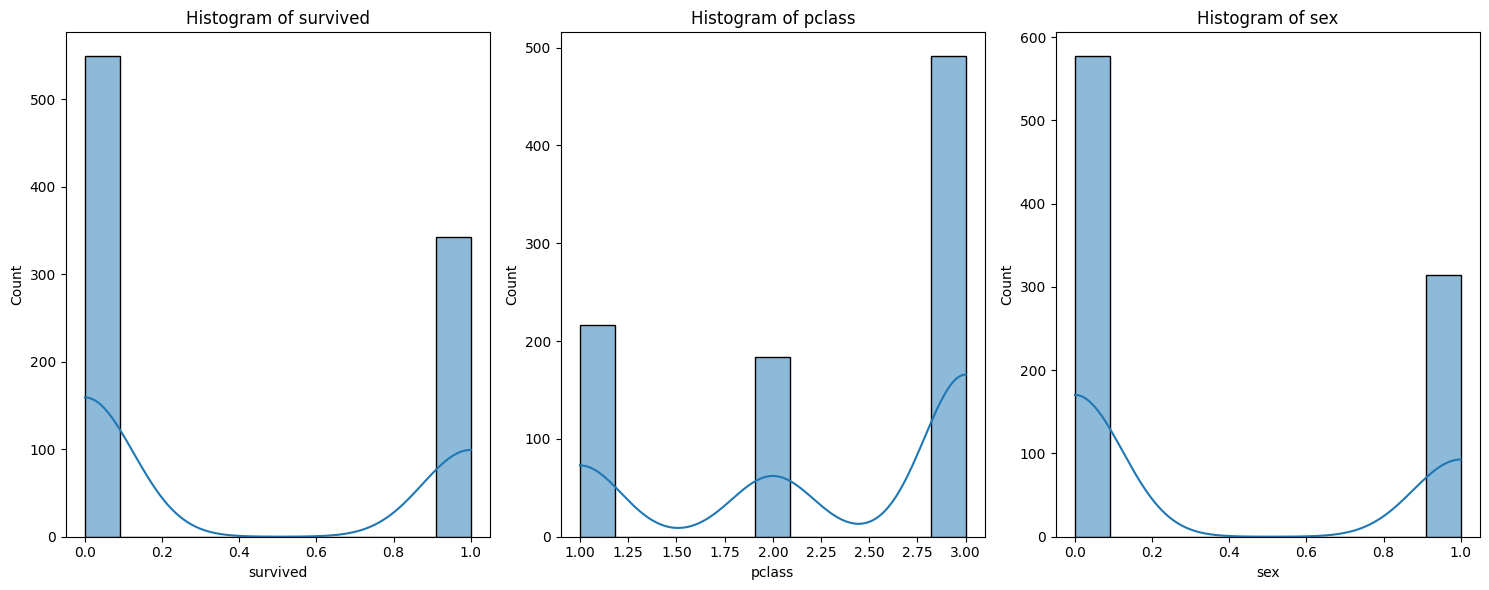

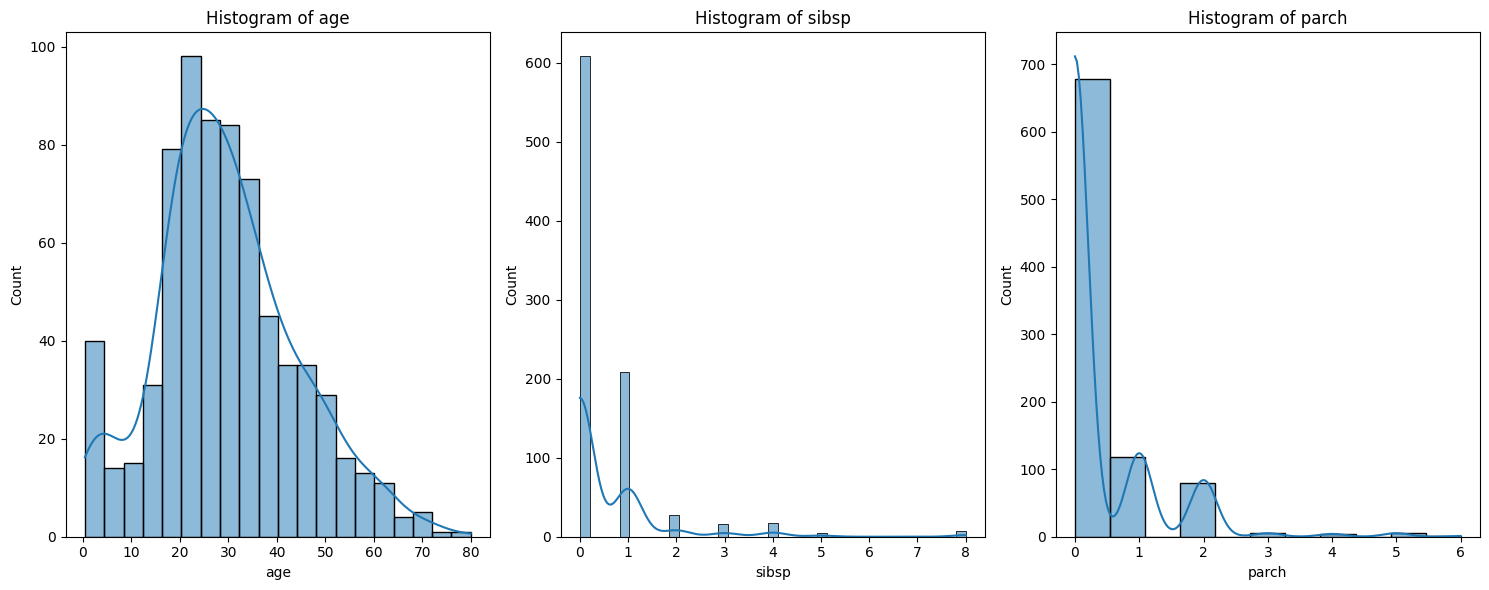

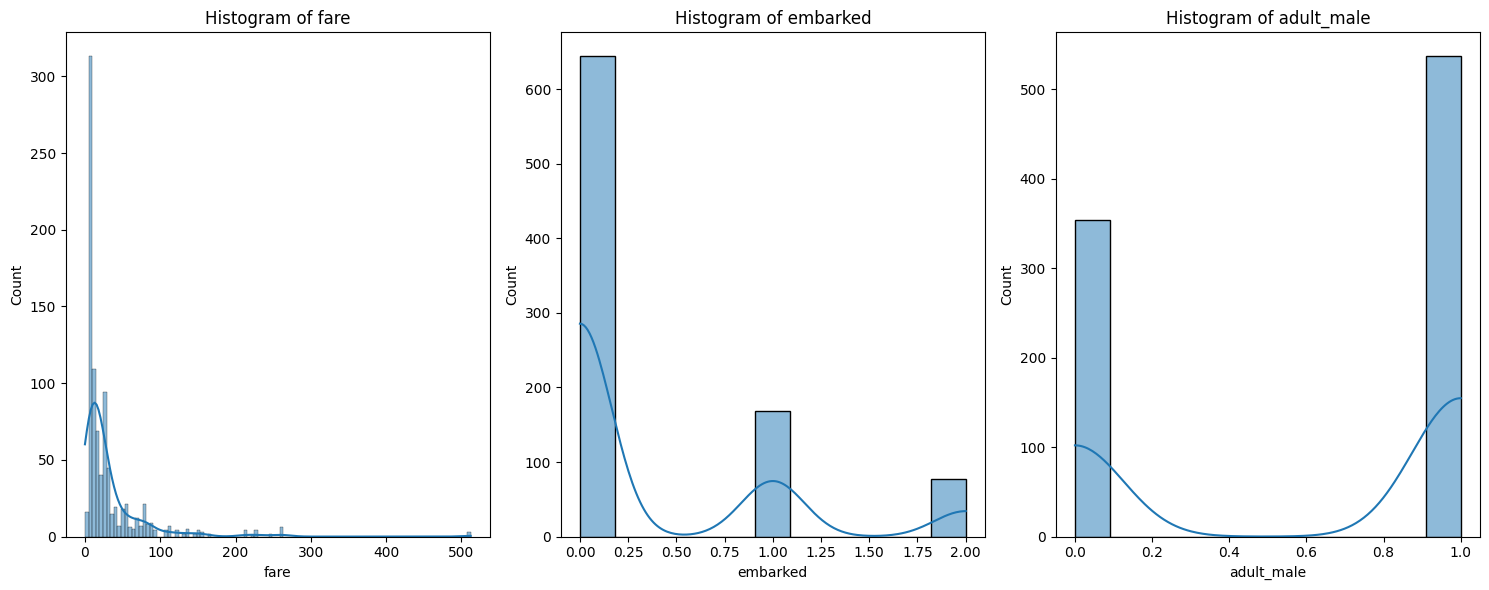

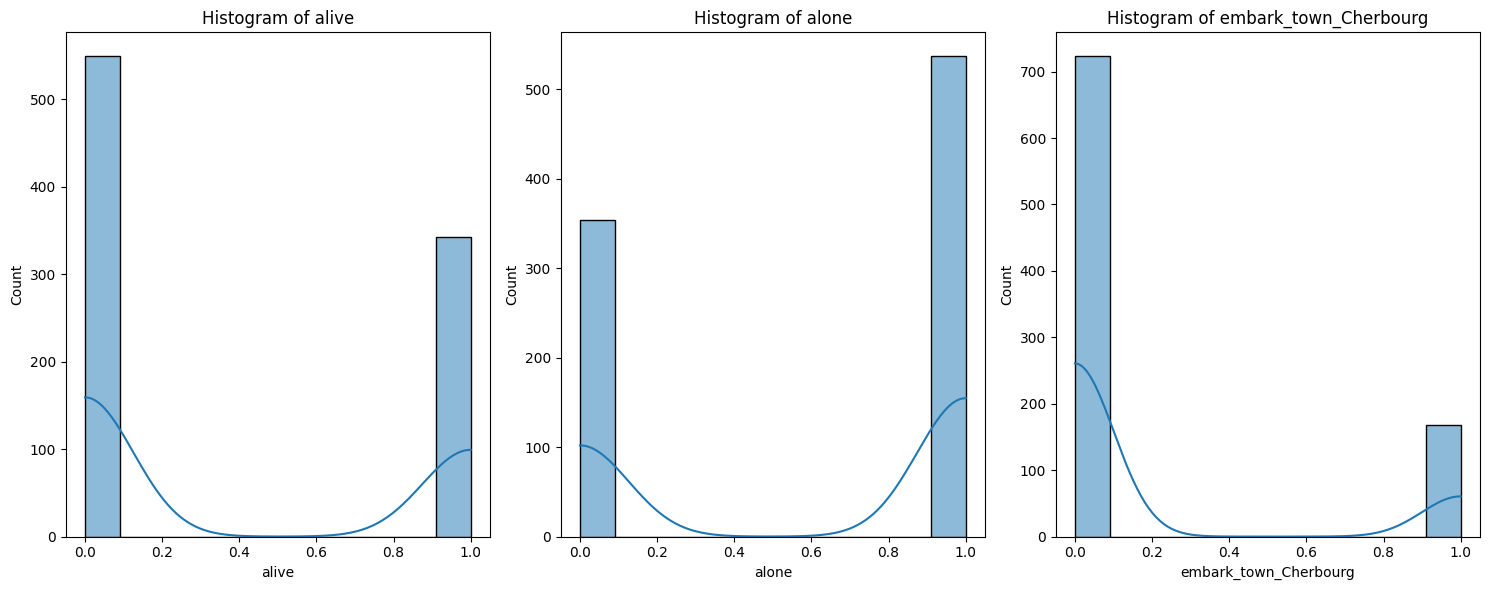

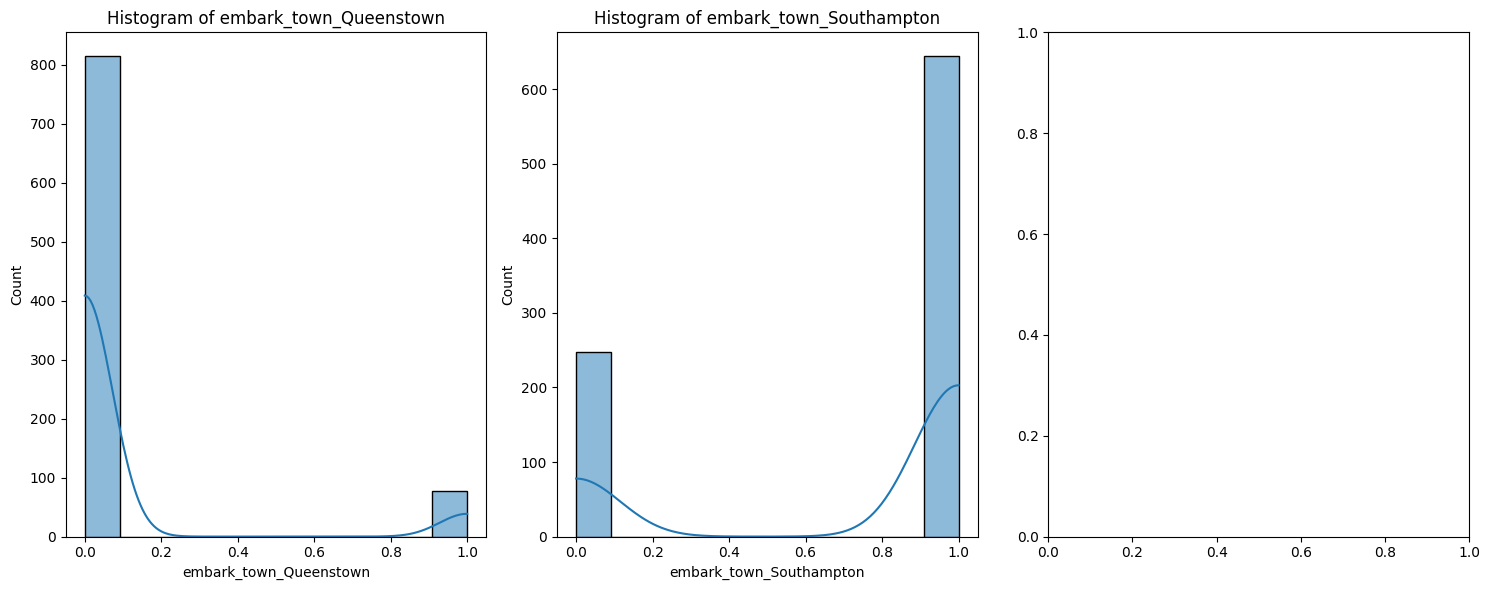

In [14]:
numeric_cols = titanic.select_dtypes(include=[np.number]).columns.tolist()

num_cols_per_row = 3
num_rows = len(numeric_cols) // num_cols_per_row + (len(numeric_cols) % num_cols_per_row > 0)

for i in range(num_rows):
    fig, axes = plt.subplots(1, num_cols_per_row, figsize=(15, 6))
    for j in range(num_cols_per_row):
        col_index = i * num_cols_per_row + j
        if col_index < len(numeric_cols):
            col = numeric_cols[col_index]
            sns.histplot(data=titanic, x=col, kde=True, ax=axes[j])
            axes[j].set_title(f'Histogram of {col}')
    plt.tight_layout()
    plt.show()

## **Data Preprocessing**

In [11]:
titanic['sex'] = titanic['sex'].replace({
    'male': 0,
    'female': 1
})
titanic['embarked'] = titanic['embarked'].replace({
    'S': 0,
    'C': 1,
    'Q': 2
})
titanic['class'] = titanic['class'].replace({
    'First': 0,
    'Second': 1,
    'Third': 2
})
titanic['alive'] = titanic['alive'].replace({
    'no': 0,
    'yes': 1
})
titanic[['alone', 'adult_male']] = titanic[['alone', 'adult_male']].replace({
    True: 1,
    False: 0
})
titanic.drop(['who', 'deck'], inplace=True, axis=1)
titanic = pd.get_dummies(titanic, columns=['embark_town'])

# Print the dataframe
titanic.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,adult_male,alive,alone,embark_town_Cherbourg,embark_town_Queenstown,embark_town_Southampton
0,0,3,0,22.0,1,0,7.2500,0.0,2,1,0,0,0,0,1
1,1,1,1,38.0,1,0,71.2833,1.0,0,0,1,0,1,0,0
2,1,3,1,26.0,0,0,7.9250,0.0,2,0,1,1,0,0,1
3,1,1,1,35.0,1,0,53.1000,0.0,0,0,1,0,0,0,1
4,0,3,0,35.0,0,0,8.0500,0.0,2,1,0,1,0,0,1


## **Fit & Predict**

In [ ]:
# Impute missing values using Random Forests

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(titanic.drop('survived', axis=1), titanic['survived'], test_size=0.3, random_state=42)

# Create an imputer object with a Random Forest estimator
imp = IterativeImputer(RandomForestRegressor(n_estimators=10, random_state=0), max_iter=10, random_state=0)

# Train the imputer on the training data
imp.fit(X_train)

# Transform the training and test sets
X_train_imp = imp.transform(X_train)
X_train_imp = pd.DataFrame(X_train_imp, columns=X_train.columns)
X_test_imp = imp.transform(X_test)

# Create a new Random Forests classifier using the imputed data
clf = RandomForestClassifier(n_trees=100, max_depth=10)
clf.fit(X_train_imp, y_train)

# Make predictions and evaluate
y_pred = clf.predict(X_test_imp)
print(f"Test Accuracy: {(y_test==y_pred).mean():.2%}")

Test Accuracy: 100.00%
